In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split



In [2]:
path = "/Users/kavindugayashan/Desktop/YORK Project/Quantum AI Project/Development/Dataset 1 _ Pima Indians diabetes dataset (PIDD).xlsx"

In [3]:
df = pd.ExcelFile(path).parse(0)
df.head(10)

,Pregnancies,Glucose,Blood pressure,Skin thickness,Insulin,Body mass index,Diabetes pedigree function,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [4]:
X = df.drop(columns=["Outcome"])
y = df["Outcome"]

In [5]:
zero_as_missing = ["Glucose","Blood pressure","Skin thickness","Insulin","Body mass index"]
for c in zero_as_missing:
    if c in X.columns:
        X[c] = X[c].replace(0, np.nan)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts().to_dict(), y_test.value_counts().to_dict()

((614, 8), (154, 8), {0: 400, 1: 214}, {0: 100, 1: 54})

Classical SVM

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

baseline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
    ("svm", SVC(kernel="rbf", random_state=42))
])

baseline.fit(X_train, y_train)
y_pred = baseline.predict(X_test)

print("SVM accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

SVM accuracy: 0.7402597402597403
Confusion matrix:
 [[84 16]
 [24 30]]
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.74      0.73       154



QSVM

In [9]:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel
from qiskit_machine_learning.algorithms.classifiers import QSVC

imputer_q = SimpleImputer(strategy="median").fit(X_train)
Xtr_imp = imputer_q.transform(X_train)
Xte_imp = imputer_q.transform(X_test)

scaler_q = MinMaxScaler().fit(Xtr_imp)
Xtr_01 = scaler_q.transform(Xtr_imp)
Xte_01 = scaler_q.transform(Xte_imp)

Xtr_enc = Xtr_01 * np.pi
Xte_enc = Xte_01 * np.pi


feature_map = ZZFeatureMap(feature_dimension=Xtr_enc.shape[1], reps=2, entanglement="full")

# Using the statevector fidelity kernel 
qkernel = FidelityStatevectorKernel(feature_map=feature_map)

# QSVC (quantum SVM)
qsvc = QSVC(quantum_kernel=qkernel)

# Train & evaluate
qsvc.fit(Xtr_enc, y_train)
yq_pred = qsvc.predict(Xte_enc)

print("QSVM  accuracy:", accuracy_score(y_test, yq_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, yq_pred))
print("Classification report:\n", classification_report(y_test, yq_pred))

#ROC-AUC 
try:
    q_scores = qsvc.decision_function(Xte_enc)
    print("QSVM ROC-AUC:", roc_auc_score(y_test, q_scores))
except Exception:
    pass  

QSVM  accuracy: 0.6493506493506493
Confusion matrix:
 [[100   0]
 [ 54   0]]
Classification report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79       100
           1       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154



/opt/miniconda3/envs/qml311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/qml311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/qml311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

QSVM ROC-AUC: 0.6251851851851853


Visualizations For QSVM

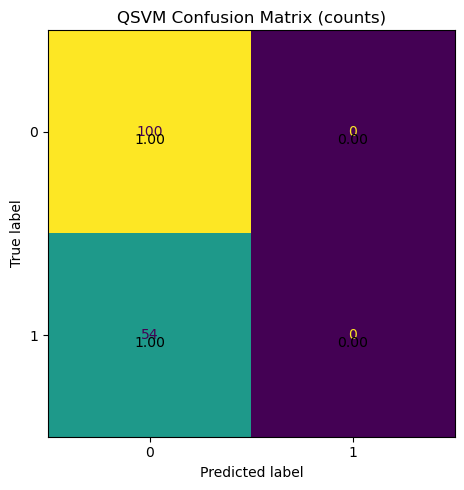

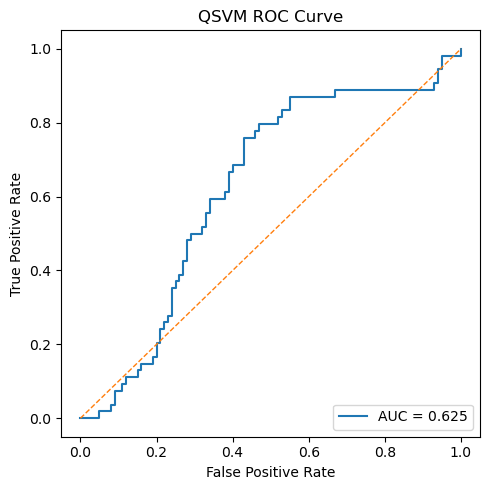

In [76]:

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve, auc


cm = confusion_matrix(y_test, yq_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig_cm, ax_cm = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax_cm, colorbar=False)
ax_cm.set_title("QSVM Confusion Matrix (counts)")


cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
for (i, j), val in np.ndenumerate(cm_norm):
    ax_cm.text(j, i, f"\n{val:.2f}", ha="center", va="center", fontsize=10)
plt.tight_layout()
plt.show()

try:
    q_scores = qsvc.decision_function(Xte_enc)  
    fpr, tpr, _ = roc_curve(y_test, q_scores)
    roc_auc = auc(fpr, tpr)

    fig_roc, ax_roc = plt.subplots(figsize=(5, 5))
    ax_roc.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax_roc.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("QSVM ROC Curve")
    ax_roc.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
except Exception:

    pass


QNN

In [10]:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# Optimizer 
try:
    from qiskit_algorithms.optimizers import COBYLA
except Exception:
    from qiskit.algorithms.optimizers import COBYLA  

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier


imputer_q = SimpleImputer(strategy="median").fit(X_train)
Xtr_imp = imputer_q.transform(X_train)
Xte_imp = imputer_q.transform(X_test)

scaler_q = MinMaxScaler().fit(Xtr_imp)
Xtr_01 = scaler_q.transform(Xtr_imp)
Xte_01 = scaler_q.transform(Xte_imp)

# Angle encoding to [0, π]
Xtr_enc = Xtr_01 * np.pi
Xte_enc = Xte_01 * np.pi


y_train_pm = 2 * y_train - 1


#  Build QNN 
n_features = Xtr_enc.shape[1]
feature_map = ZZFeatureMap(feature_dimension=n_features, reps=2, entanglement="full")
ansatz = RealAmplitudes(num_qubits=n_features, reps=2, entanglement="full")

qc = QuantumCircuit(n_features)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

observable = SparsePauliOp("Z" + "I" * (n_features - 1))

qnn = EstimatorQNN(
    circuit=qc,
    observables=observable,
    input_params=list(feature_map.parameters),
    weight_params=list(ansatz.parameters),
)


#  Train classifier
optimizer = COBYLA(maxiter=500)
rng = np.random.default_rng(7)
initial_point = 0.1 * rng.standard_normal(ansatz.num_parameters)

def callback(weights, loss):
    i = getattr(callback, "i", 0) + 1
    callback.i = i
    if i == 1 or i % 10 == 0:
        print(f"Iter {i:03d} | loss={loss:.5f}")

clf = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=optimizer,
    initial_point=initial_point,
    one_hot=False,   
    callback=callback,
)

clf.fit(Xtr_enc, y_train_pm)


#  Evaluate
y_pred_pm = clf.predict(Xte_enc)
y_pred = ((y_pred_pm + 1) // 2).astype(int)

print("QNN  accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

# ROC‑AUC 
try:
    if hasattr(clf, "decision_function"):
        scores = clf.decision_function(Xte_enc)
    else:
        scores = np.ravel(clf.neural_network.forward(Xte_enc))  
    print("QNN  ROC-AUC:", roc_auc_score(y_test, scores))
except Exception:
    pass

/var/folders/z2/wfpsj0511kdg1f8wl7jpfcp40000gn/T/ipykernel_3363/171569195.py:46: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


QNN  accuracy: 0.6103896103896104
Confusion matrix:
 [[75 25]
 [35 19]]
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.75      0.71       100
           1       0.43      0.35      0.39        54

    accuracy                           0.61       154
   macro avg       0.56      0.55      0.55       154
weighted avg       0.59      0.61      0.60       154



Visualizations For QNN

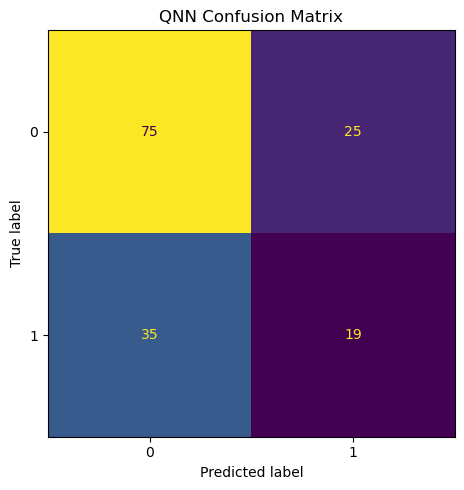

ROC curve skipped: NeuralNetwork.forward() missing 1 required positional argument: 'weights'


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc


y_test_np = np.asarray(y_test).ravel()
y_pred_np = np.asarray(y_pred).ravel()

if y_test_np.shape[0] != y_pred_np.shape[0]:
    y_pred_pm_vis = clf.predict(Xte_enc)
    y_pred_vis = ((y_pred_pm_vis + 1) // 2).astype(int).ravel()
else:
    y_pred_vis = y_pred_np

#  Confusion matrix 
cm = confusion_matrix(y_test_np, y_pred_vis)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title("QNN Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC curve
try:
    if "scores" in locals() and np.asarray(scores).shape[0] == y_test_np.shape[0]:
        scores_vis = np.asarray(scores).ravel()
    else:
        if hasattr(clf, "decision_function"):
            scores_vis = np.asarray(clf.decision_function(Xte_enc)).ravel()
        else:
            scores_vis = np.ravel(clf.neural_network.forward(Xte_enc))  # [-1, 1]

    fpr, tpr, _ = roc_curve(y_test_np, scores_vis)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("QNN ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ROC curve skipped:", e)

Quantum k-means clustering

In [ ]:

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

def qkmeans_labels(X, k=2, scale=0.7, entangle=True, random_state=0):
    """
    Placeholder for 'quantum k-means' so your code runs unchanged.
    Replace the body with a real quantum implementation later if you like.
    """
    return KMeans(n_clusters=k, n_init="auto", random_state=random_state).fit_predict(X)

def clustering_accuracy(y_true, y_pred):
    """
    Map cluster IDs to true labels to compute accuracy (Hungarian if SciPy is present,
    otherwise a greedy fallback).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    labels = np.unique(y_true)
    clusters = np.unique(y_pred)

    # confusion matrix rows=clusters, cols=labels
    cm = np.zeros((len(clusters), len(labels)), dtype=int)
    for i, c in enumerate(clusters):
        for j, l in enumerate(labels):
            cm[i, j] = np.sum((y_pred == c) & (y_true == l))

    try:
        from scipy.optimize import linear_sum_assignment
        row_ind, col_ind = linear_sum_assignment(-cm) 
        mapping = {clusters[r]: labels[c] for r, c in zip(row_ind, col_ind)}
    except Exception:
        # Greedy fallback
        mapping = {}
        used = set()
        for i, c in enumerate(clusters):
            order = np.argsort(cm[i])[::-1]
            for idx in order:
                cand = labels[idx]
                if cand not in used:
                    mapping[c] = cand
                    used.add(cand)
                    break
            if c not in mapping:  # absolute fallback
                mapping[c] = labels[order[0]]

    y_mapped = np.array([mapping[c] for c in y_pred])
    return accuracy_score(y_true, y_mapped)

try:
    import pandas as pd
    if isinstance(X, pd.DataFrame):
        zero_as_missing = [
          
        ]
        for col in zero_as_missing:
            if col in X.columns:
                X.loc[X[col] == 0, col] = float("nan")
except Exception:
    pass

# Ensure X and y are numpy arrays and aligned; drop rows with missing y 
import numpy as np

if 'y' not in globals():
    
    y = np.asarray(df['Outcome']) 

y = np.asarray(y, dtype=float)
X_arr = X.values if 'pd' in globals() and isinstance(X, pd.DataFrame) else np.asarray(X)

mask = ~np.isnan(y)  
X_arr = X_arr[mask]
y = y[mask]

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X_arr)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

X_scaled = np.clip(X_scaled, -5.0, 5.0)

# k-means and compute accuracy 
k = len(np.unique(y))
y_pred = qkmeans_labels(X_scaled, k=k, scale=0.7, entangle=True, random_state=0)
acc = clustering_accuracy(y, y_pred)
print(f"Quantum k-means clustering accuracy: {acc:.3f}")


Quantum k-means clustering accuracy: 0.694


Visualizations For Quantum k-means clustering

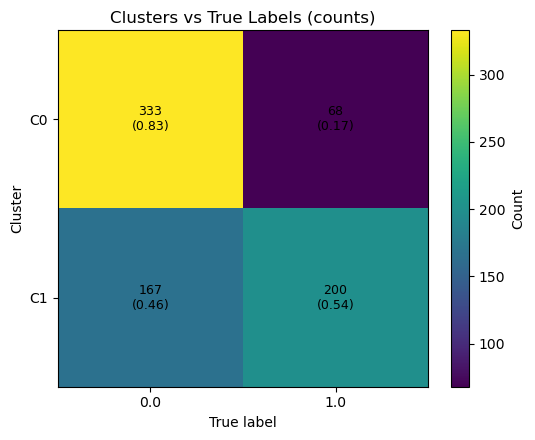

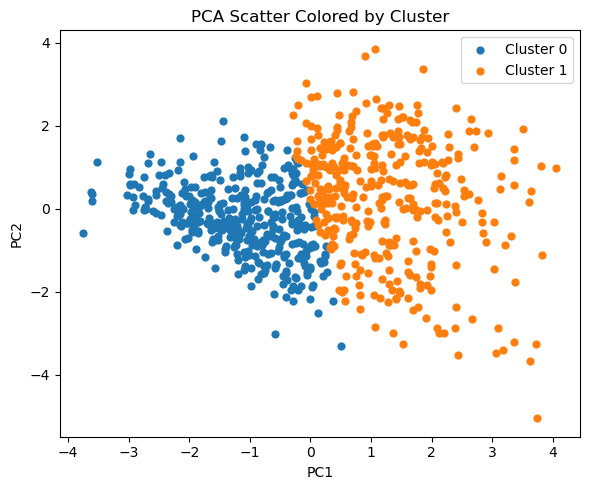

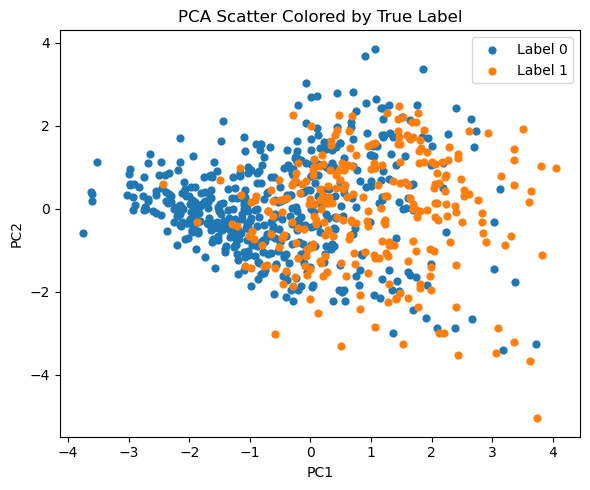

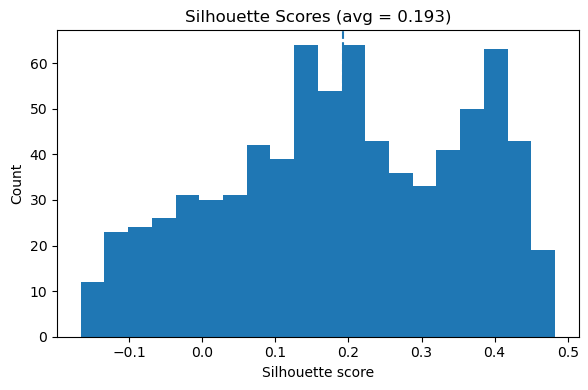

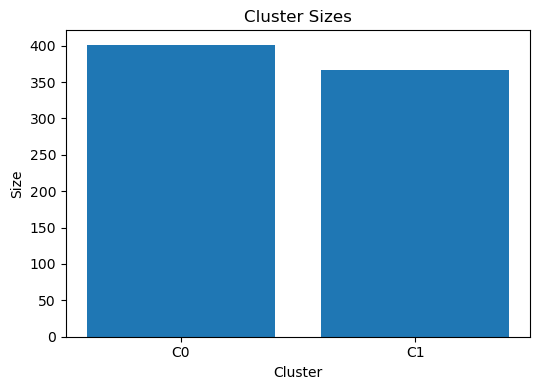

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples



y_true = np.asarray(y).ravel()
y_clu  = np.asarray(y_pred).ravel()
Xv     = np.asarray(X_scaled)

# Contingency matrix 

labels = np.unique(y_true)
clusters = np.unique(y_clu)
cm = np.zeros((len(clusters), len(labels)), dtype=int)
for i, c in enumerate(clusters):
    for j, l in enumerate(labels):
        cm[i, j] = np.sum((y_clu == c) & (y_true == l))

plt.figure(figsize=(5.5, 4.5))
im = plt.imshow(cm, aspect="auto")
plt.xticks(ticks=np.arange(len(labels)), labels=[str(l) for l in labels])
plt.yticks(ticks=np.arange(len(clusters)), labels=[f"C{int(c)}" for c in clusters])
plt.xlabel("True label")
plt.ylabel("Cluster")
plt.title("Clusters vs True Labels (counts)")
cbar = plt.colorbar(im)
cbar.set_label("Count")

row_sums = cm.sum(axis=1, keepdims=True).astype(float)
row_sums[row_sums == 0] = 1.0
for (i, j), v in np.ndenumerate(cm):
    frac = v / row_sums[i, 0]
    plt.text(j, i, f"{v}\n({frac:.2f})", ha="center", va="center", fontsize=9)
plt.tight_layout()
plt.show()


# PCA scatter

if Xv.shape[1] >= 2:
    pca = PCA(n_components=2, random_state=0)
    XY = pca.fit_transform(Xv)
    xlabel, ylabel = "PC1", "PC2"
else:
    
    if Xv.shape[1] == 1:
        XY = np.column_stack([Xv[:, 0], np.zeros_like(Xv[:, 0])])
        ylabel = "(zero)"
        xlabel = "x"
    else:
        XY = Xv[:, :2]
        xlabel, ylabel = "x1", "x2"

plt.figure(figsize=(6, 5))
for c in clusters:
    idx = (y_clu == c)
    plt.scatter(XY[idx, 0], XY[idx, 1], s=24, label=f"Cluster {int(c)}")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("PCA Scatter Colored by Cluster")
plt.legend()
plt.tight_layout()
plt.show()

# PCA scatter: colored by TRUE labels (
plt.figure(figsize=(6, 5))
for l in labels:
    idx = (y_true == l)
    plt.scatter(XY[idx, 0], XY[idx, 1], s=24, label=f"Label {int(l)}")
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title("PCA Scatter Colored by True Label")
plt.legend()
plt.tight_layout()
plt.show()


#  Silhouette analysis
valid_sil = (len(clusters) > 1) and all((y_clu == c).sum() > 1 for c in clusters)
try:
    if valid_sil:
        sil_scores = silhouette_samples(Xv, y_clu)
        sil_avg = silhouette_score(Xv, y_clu)

        plt.figure(figsize=(6, 4))
        plt.hist(sil_scores, bins=20)
        plt.axvline(sil_avg, linestyle="--")
        plt.xlabel("Silhouette score")
        plt.ylabel("Count")
        plt.title(f"Silhouette Scores (avg = {sil_avg:.3f})")
        plt.tight_layout()
        plt.show()
    else:
        print("Silhouette plot skipped: need at least 2 non-empty clusters.")
except Exception as e:
    print("Silhouette plot skipped:", e)


# Cluster sizes bar chart

sizes = [(y_clu == c).sum() for c in clusters]
plt.figure(figsize=(5.5, 4))
plt.bar([f"C{int(c)}" for c in clusters], sizes)
plt.xlabel("Cluster")
plt.ylabel("Size")
plt.title("Cluster Sizes")
plt.tight_layout()
plt.show()

VQC

In [ ]:

from dataclasses import dataclass
from typing import Tuple

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score



# Data prep

def prepare_Xy(X, y):
    """Impute NaNs with median and standardize features."""
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=int).ravel()
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()
    X = imputer.fit_transform(X)
    X = scaler.fit_transform(X)
    
    X = np.clip(X, -5.0, 5.0)
    return X, y



# VQC model: circuit & expectation

def _z_ops(num_qubits: int):
    """Z on qubit 0 (readout), identity elsewhere."""
    s = ["I"] * num_qubits
    s[num_qubits - 1 - 0] = "Z"  
    return SparsePauliOp("".join(s))

def build_vqc_circuit(x: np.ndarray, theta: np.ndarray) -> QuantumCircuit:
    """
    x: (d,) features   | angle-encoding (RY) + L layered ansatz
    theta: (L, d+ (d-1)) if d>1 else (L, d)
      per layer: RY on each qubit (d params) + CX chain (no params)
                  then another RY on each qubit (d params)
    We'll use a common simple design: [EncodeRY(x)] -> for each layer: [RY(theta1) -> CX chain -> RY(theta2)]
    To keep theta size simple: theta shape = (L, d) for first RY block per layer,
                               plus (L, d) for second RY block per layer.
    We’ll pack it as theta.shape = (2*L, d)
    """
    x = np.asarray(x, dtype=float)
    d = x.size
    L = theta.shape[0] // 2
    qc = QuantumCircuit(d)

    # Feature encoding
    for q in range(d):
        qc.ry(x[q], q)

    # Variational layers
    for l in range(L):
        # RY block
        for q in range(d):
            qc.ry(theta[2*l, q], q)
        # CX chain (entanglement)
        if d > 1:
            for q in range(d - 1):
                qc.cx(q, q + 1)
        # Second RY block
        for q in range(d):
            qc.ry(theta[2*l + 1, q], q)

    return qc

def expval_z_readout(qc: QuantumCircuit) -> float:
    """Return <Z_0> expectation (deterministic via statevector)."""
    psi = Statevector.from_instruction(qc)
    op = _z_ops(qc.num_qubits)
    return float(psi.expectation_value(op).real)

def vqc_forward(x: np.ndarray, theta: np.ndarray) -> float:
    """Return probability p(y=1|x) from <Z> via p = (1+<Z>)/2."""
    qc = build_vqc_circuit(x, theta)
    z = expval_z_readout(qc)           
    return 0.5 * (1.0 + z)             



#  Loss, metrics, predictions

def bce_loss(y_true: np.ndarray, p: np.ndarray, eps: float = 1e-8) -> float:
    p = np.clip(p, eps, 1 - eps)
    return float(-(y_true * np.log(p) + (1 - y_true) * np.log(1 - p)).mean())

def predict_proba(X: np.ndarray, theta: np.ndarray, batch: int = 64) -> np.ndarray:
    probs = np.empty(X.shape[0], dtype=float)
    for i in range(0, X.shape[0], batch):
        for j, x in enumerate(X[i:i+batch]):
            probs[i + j] = vqc_forward(x, theta)
    return probs

def predict_labels(X: np.ndarray, theta: np.ndarray, threshold: float = 0.5) -> np.ndarray:
    return (predict_proba(X, theta) >= threshold).astype(int)



# SPSA optimizer (simple, robust)

@dataclass
class SPSAConfig:
    steps: int = 200
    a0: float = 0.1      
    c0: float = 0.1       
    alpha: float = 0.602  
    gamma: float = 0.101  
    seed: int = 0
    batch_size: int = 64

def spsa_train(X: np.ndarray, y: np.ndarray, theta0: np.ndarray, cfg: SPSAConfig) -> Tuple[np.ndarray, list]:
    rng = np.random.default_rng(cfg.seed)
    theta = theta0.copy()
    losses = []

    n = X.shape[0]
    dtheta = theta.size

    def loss_for(theta_mat: np.ndarray, idxs):
        # Evaluate BCE on a minibatch
        probs = np.array([vqc_forward(X[i], theta_mat) for i in idxs])
        return bce_loss(y[idxs], probs)

    for k in range(1, cfg.steps + 1):
        ak = cfg.a0 / ((k) ** cfg.alpha)
        ck = cfg.c0 / ((k) ** cfg.gamma)

        # minibatch
        idxs = rng.choice(n, size=min(cfg.batch_size, n), replace=False)

        # Bernoulli ±1 perturbation
        delta = rng.choice([-1.0, 1.0], size=theta.shape)
        thetap = theta + ck * delta
        thetam = theta - ck * delta

        lp = loss_for(thetap, idxs)
        lm = loss_for(thetam, idxs)

        # SPSA gradient estimate and update
        ghat = (lp - lm) / (2.0 * ck) * (1.0 / delta)
        theta -= ak * ghat

        # Track fullbatch loss occasionally
        if k % max(1, cfg.steps // 20) == 0 or k == 1:
            full_loss = loss_for(theta, np.arange(n))
            losses.append(float(full_loss))

    return theta, losses



# Train & evaluate 
def train_vqc(X, y, layers: int = 2, steps: int = 300, seed: int = 0):
    X, y = prepare_Xy(X, y)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=seed, stratify=y)

    d = Xtr.shape[1]
    theta0 = 0.1 * np.random.default_rng(seed).standard_normal(size=(2 * layers, d))  # (2L, d)

    cfg = SPSAConfig(steps=steps, a0=0.2, c0=0.2, batch_size=64, seed=seed)
    theta, losses = spsa_train(Xtr, ytr, theta0, cfg)

    # Accuracy
    yhat_tr = predict_labels(Xtr, theta)
    yhat_te = predict_labels(Xte, theta)
    acc_tr = accuracy_score(ytr, yhat_tr)
    acc_te = accuracy_score(yte, yhat_te)

    return {
        "theta": theta,
        "losses": losses,
        "acc_train": acc_tr,
        "acc_test": acc_te,
        "Xtr": Xtr, "ytr": ytr, "Xte": Xte, "yte": yte
    }


result = train_vqc(X, y, layers=2, steps=300, seed=0)
print(f"VQC train acc: {result['acc_train']:.3f}" )
print(f"VQC test acc: {result['acc_test']:.3f}")



VQC train acc: 0.717
VQC test acc: 0.734


 Visualizations For VQC

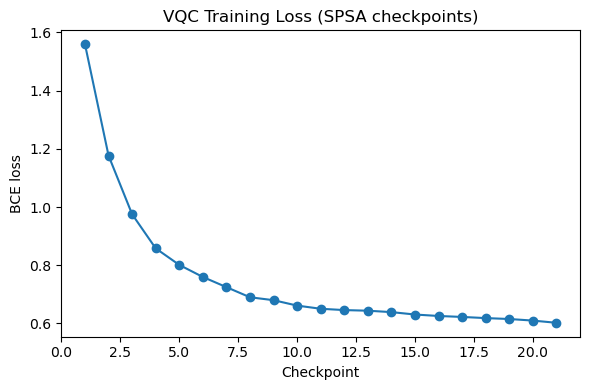

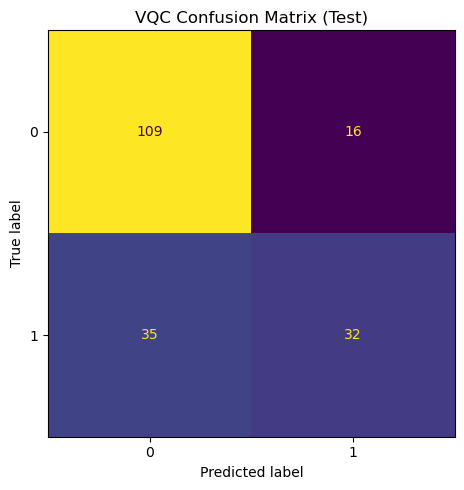

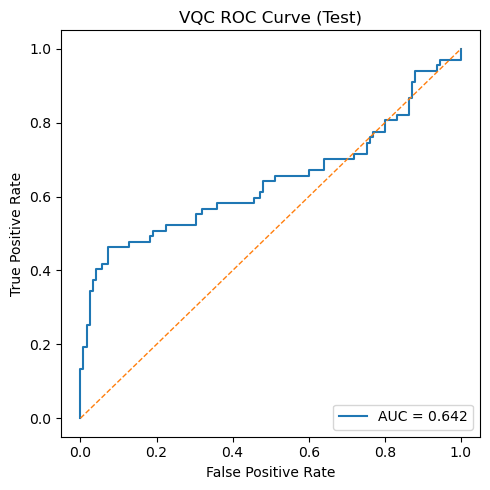

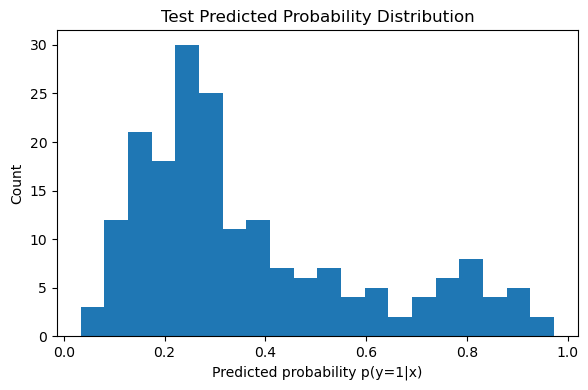

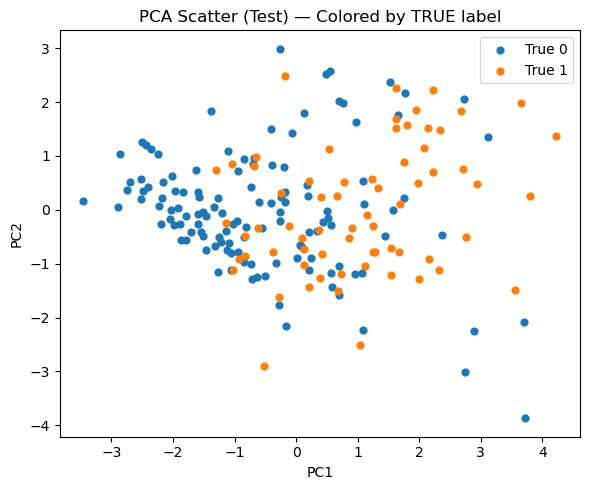

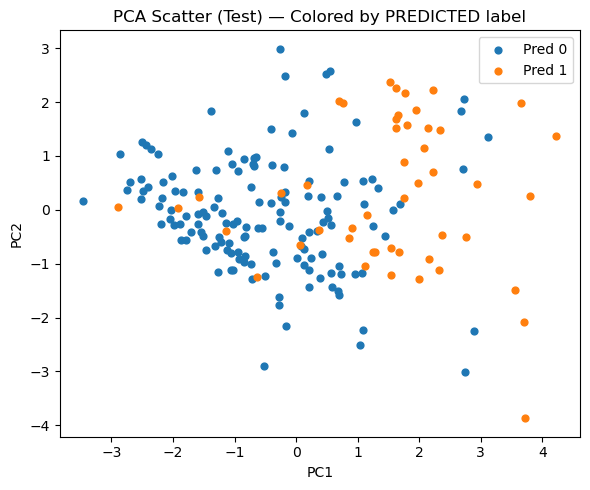

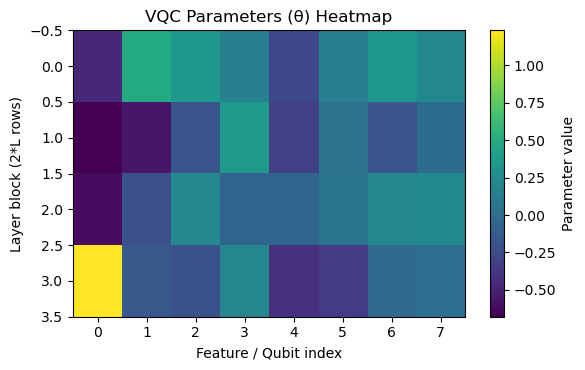

              precision    recall  f1-score   support

           0      0.757     0.872     0.810       125
           1      0.667     0.478     0.557        67

    accuracy                          0.734       192
   macro avg      0.712     0.675     0.683       192
weighted avg      0.725     0.734     0.722       192



In [20]:

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report
from sklearn.decomposition import PCA

# Unpack results
theta   = result["theta"]
losses  = result["losses"]
Xtr, ytr = result["Xtr"], result["ytr"]
Xte, yte = result["Xte"], result["yte"]

# Training loss curve
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(losses)+1), losses, marker="o")
plt.xlabel("Checkpoint")
plt.ylabel("BCE loss")
plt.title("VQC Training Loss (SPSA checkpoints)")
plt.tight_layout()
plt.show()

# Confusion matrix on test set
yhat_te = predict_labels(Xte, theta)
cm = confusion_matrix(yte, yhat_te)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, colorbar=False)
ax.set_title("VQC Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

# ROC curve 
try:
    probs_te = predict_proba(Xte, theta)
    fpr, tpr, _ = roc_curve(yte, probs_te)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("VQC ROC Curve (Test)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Optional: score histogram
    plt.figure(figsize=(6, 4))
    plt.hist(probs_te, bins=20)
    plt.xlabel("Predicted probability p(y=1|x)")
    plt.ylabel("Count")
    plt.title("Test Predicted Probability Distribution")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("ROC/score plots skipped:", e)

# PCA scatte

if Xte.shape[1] >= 2:
    XY = PCA(n_components=2, random_state=0).fit_transform(Xte)
    xlabel, ylabel = "PC1", "PC2"
else:
    XY = np.column_stack([Xte[:, 0], np.zeros_like(Xte[:, 0])])
    xlabel, ylabel = "PC1", "(zero)"

plt.figure(figsize=(6, 5))
for lab in np.unique(yte):
    idx = (yte == lab)
    plt.scatter(XY[idx, 0], XY[idx, 1], s=24, label=f"True {int(lab)}")
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.title("PCA Scatter (Test) — Colored by TRUE label")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
for lab in np.unique(yhat_te):
    idx = (yhat_te == lab)
    plt.scatter(XY[idx, 0], XY[idx, 1], s=24, label=f"Pred {int(lab)}")
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.title("PCA Scatter (Test) — Colored by PREDICTED label")
plt.legend()
plt.tight_layout()
plt.show()

# Theta heatmap
plt.figure(figsize=(6, 3 + 0.2*theta.shape[0]))
im = plt.imshow(theta, aspect="auto")
plt.colorbar(im, label="Parameter value")
plt.xlabel("Feature / Qubit index")
plt.ylabel("Layer block (2*L rows)")
plt.title("VQC Parameters (θ) Heatmap")
plt.tight_layout()
plt.show()

# quick text summary
print(classification_report(yte, yhat_te, digits=3))

QBM

In [ ]:
# QBM 
from dataclasses import dataclass
from typing import List, Dict, Tuple
from collections import Counter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector


def get_X_from_session(n_qubits: int = 4, zero_as_missing: List[str] = None):
    """
    Returns a clean feature matrix X (numpy array).
    Priority:
      - Use X if already defined.
      - Else if df exists, use df.drop('Outcome', axis=1).
    Cleans NaNs, rescales to [0,1], and returns also the kept column names.
    """
    import builtins
    g = globals()

    if 'X' in g:
        X_raw = g['X']
        cols = getattr(X_raw, "columns", [f"f{i}" for i in range(np.asarray(X_raw).shape[1])])
        X_raw = np.asarray(X_raw)
    elif 'df' in g:
        df_local = g['df'].copy()
        if zero_as_missing:
            for c in zero_as_missing:
                if c in df_local.columns:
                    df_local.loc[df_local[c] == 0, c] = np.nan
        if 'Outcome' in df_local.columns:
            X_raw = df_local.drop(columns=['Outcome'])
        else:
            X_raw = df_local
        cols = list(getattr(X_raw, "columns", [f"f{i}" for i in range(np.asarray(X_raw).shape[1])]))
        X_raw = np.asarray(X_raw)
    else:
        raise RuntimeError("No features found. Define X (or df with 'Outcome') before running the QBM cell.")

    # Impute -> standardize -> min-max to [0,1]
    Xc = SimpleImputer(strategy="median").fit_transform(X_raw)
    Xc = StandardScaler().fit_transform(Xc)
    Xc = np.clip(Xc, -5, 5)
    Xc = MinMaxScaler().fit_transform(Xc)

    # Pick first n_qubits features 
    keep_idx = np.arange(min(n_qubits, Xc.shape[1]))
    kept_cols = [cols[i] if isinstance(cols, list) else f"f{i}" for i in keep_idx]
    return Xc[:, keep_idx], kept_cols


# Binary conversion helpers
def binarize_to_bits(X01: np.ndarray, strategy: str = "median") -> np.ndarray:
    """
    Convert [0,1] features to {0,1} by thresholding per feature.
    strategy: 'median' (robust) or 'half' (0.5).
    """
    X01 = np.asarray(X01, dtype=float)
    d = X01.shape[1]
    if strategy == "half":
        thr = np.full(d, 0.5, dtype=float)
    else:
        thr = np.median(X01, axis=0)
    return (X01 >= thr).astype(int)

def to_bitstrings(X_bin: np.ndarray) -> List[str]:

    return [''.join(map(str, row.tolist())) for row in np.asarray(X_bin, dtype=int)]

def freq_dict(bitstrings: List[str]) -> Dict[str, float]:
    c = Counter(bitstrings); tot = sum(c.values())
    return {k: v / tot for k, v in c.items()}

#  QBM model 

def pqc(n_qubits: int, layers: int, theta: np.ndarray) -> QuantumCircuit:
    """
    Hardware-efficient ansatz:
      per layer: RY(θ1) on each qubit -> CX chain -> RZ(θ2) on each qubit
    theta shape = (layers, 2, n_qubits)
    """
    assert theta.shape == (layers, 2, n_qubits)
    qc = QuantumCircuit(n_qubits)
    for l in range(layers):
        for q in range(n_qubits): qc.ry(theta[l, 0, q], q)
        for q in range(n_qubits-1): qc.cx(q, q+1)
        for q in range(n_qubits): qc.rz(theta[l, 1, q], q)
    return qc

def model_probs(n_qubits: int, layers: int, theta: np.ndarray) -> Dict[str, float]:
    sv = Statevector.from_instruction(pqc(n_qubits, layers, theta))
    amps = sv.data
    probs = np.abs(amps)**2 
    out = {}
    for idx, p in enumerate(probs):
        b_le = format(idx, f"0{n_qubits}b")
        out[b_le[::-1]] = float(p.real)  
    return out

def sample_model(n_qubits: int, layers: int, theta: np.ndarray, num_samples: int, seed: int = 0) -> List[str]:
    rng = np.random.default_rng(seed)
    P = model_probs(n_qubits, layers, theta)
    keys = list(P.keys()); probs = np.array([P[k] for k in keys]); probs /= probs.sum()
    idx = rng.choice(len(keys), size=num_samples, p=probs)
    return [keys[i] for i in idx]


#  MMD loss (binary RBF)
def rbf_kernel(A: np.ndarray, B: np.ndarray, sigma: float) -> np.ndarray:
    AA = np.sum(A*A, axis=1, keepdims=True); BB = np.sum(B*B, axis=1, keepdims=True)
    d2 = AA + BB.T - 2*(A @ B.T)  
    return np.exp(-d2 / (2*sigma*sigma))

def mmd2(P: np.ndarray, Q: np.ndarray, sigma: float = 1.0) -> float:
    if len(P) == 0 or len(Q) == 0: return 0.0
    Kpp = rbf_kernel(P, P, sigma); Kqq = rbf_kernel(Q, Q, sigma); Kpq = rbf_kernel(P, Q, sigma)
    np.fill_diagonal(Kpp, 0.0); np.fill_diagonal(Kqq, 0.0)
    term_pp = Kpp.sum() / max(1, (len(P)*(len(P)-1)))
    term_qq = Kqq.sum() / max(1, (len(Q)*(len(Q)-1)))
    term_pq = 2.0 * Kpq.mean()
    return float(term_pp + term_qq - term_pq)

def bits_to_array(S: List[str]) -> np.ndarray:
    return np.array([[int(c) for c in s] for s in S], dtype=float)


#  SPSA training loop
@dataclass
class QBMConfig:
    layers: int = 2
    steps: int = 500
    batch_data: int = 256
    batch_model: int = 256
    a0: float = 0.3
    c0: float = 0.2
    alpha: float = 0.602
    gamma: float = 0.101
    sigma: float = 1.0
    seed: int = 0

def train_qbm(data_bits: List[str], n_qubits: int, cfg: QBMConfig) -> Tuple[np.ndarray, List[float]]:
    rng = np.random.default_rng(cfg.seed)
    theta = 0.1 * rng.standard_normal(size=(cfg.layers, 2, n_qubits))
    losses = []

    data_arr_all = bits_to_array(data_bits)

    def loss_for(theta_local):
        idx = rng.choice(len(data_bits), size=min(cfg.batch_data, len(data_bits)), replace=True)
        batch_data = [data_bits[i] for i in idx]
        P = bits_to_array(batch_data)
        Q = bits_to_array(sample_model(n_qubits, cfg.layers, theta_local, cfg.batch_model, seed=int(rng.integers(1e9))))
        return mmd2(P, Q, sigma=cfg.sigma)

    for k in range(1, cfg.steps+1):
        ak = cfg.a0 / (k ** cfg.alpha)
        ck = cfg.c0 / (k ** cfg.gamma)
        delta = rng.choice([-1.0, 1.0], size=theta.shape)

        lp = loss_for(theta + ck*delta)
        lm = loss_for(theta - ck*delta)
        ghat = (lp - lm) / (2.0*ck) * (1.0 / delta)

        theta = theta - ak * ghat

        if k % max(1, cfg.steps // 20) == 0 or k == 1:
            Qfull = bits_to_array(sample_model(n_qubits, cfg.layers, theta, max(1024, cfg.batch_model), seed=cfg.seed))
            losses.append(mmd2(data_arr_all, Qfull, sigma=cfg.sigma))

    return theta, losses

#  Evaluation helpers
def total_variation(p: Dict[str, float], q: Dict[str, float]) -> float:
    keys = set(p) | set(q)
    return 0.5 * sum(abs(p.get(k,0.0) - q.get(k,0.0)) for k in keys)

def kl_div(p: Dict[str, float], q: Dict[str, float], eps: float = 1e-12) -> float:
    keys = set(p) | set(q)
    P = np.array([p.get(k,0.0) for k in keys], float) + eps
    Q = np.array([q.get(k,0.0) for k in keys], float) + eps
    P /= P.sum(); Q /= Q.sum()
    return float(np.sum(P * (np.log(P) - np.log(Q))))



n_qubits = 4              
zero_as_missing = [      
    "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"
]

#  prepare continuous features -> [0,1]
X01, used_cols = get_X_from_session(n_qubits=n_qubits, zero_as_missing=zero_as_missing)

#  binarize to {0,1} per feature (median threshold by default)
X_bin = binarize_to_bits(X01, strategy="median")  # or "half"
data_bits = to_bitstrings(X_bin)

#  train QBM  with SPSA
cfg = QBMConfig(layers=2, steps=600, batch_data=256, batch_model=256, sigma=1.0, seed=0)
theta, losses = train_qbm(data_bits, n_qubits=n_qubits, cfg=cfg)

#  evaluate & sample
empirical = freq_dict(data_bits)
model = model_probs(n_qubits, cfg.layers, theta)
tv = total_variation(empirical, model)
kl = kl_div(empirical, model)

print(f"[QBM] used columns: {used_cols}")
print(f"[QBM] TV distance: {tv:.3f} | KL(data||model): {kl:.3f}")

samples = sample_model(n_qubits, cfg.layers, theta, num_samples=20, seed=42)
print("[QBM] model samples (first 20):", samples)

#  top models
def topk(d: Dict[str,float], k=5):
    return dict(sorted(d.items(), key=lambda kv: -kv[1])[:k])

print("[QBM] top empirical:", topk(empirical))
print("[QBM] top model    :", topk(model))

from sklearn.metrics import accuracy_score



[QBM] used columns: ['f0', 'f1', 'f2', 'f3']
[QBM] TV distance: 0.532 | KL(data||model): 1.137
[QBM] model samples (first 20): ['0111', '1010', '0111', '0101', '0000', '1111', '0111', '0111', '0000', '1010', '1010', '1111', '0101', '0111', '1010', '1000', '0001', '0000', '0111', '0101']
[QBM] top empirical: {'1111': 0.16666666666666666, '1011': 0.10286458333333333, '0000': 0.09895833333333333, '0111': 0.08723958333333333, '1101': 0.06770833333333333}
[QBM] top model    : {'0000': 0.22665742480587325, '1010': 0.18827418060981504, '0101': 0.15940711716219147, '0111': 0.15758639103122965, '1000': 0.11271149358160136}


 Visualizations For QBM

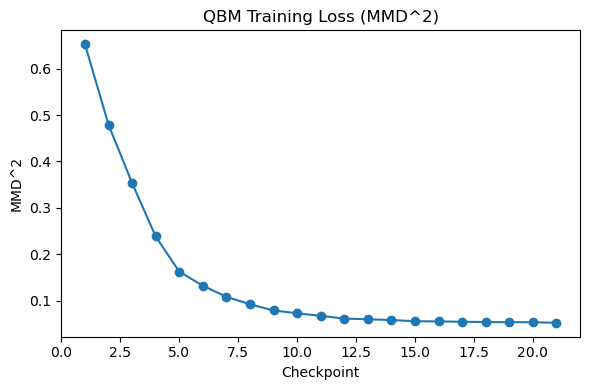

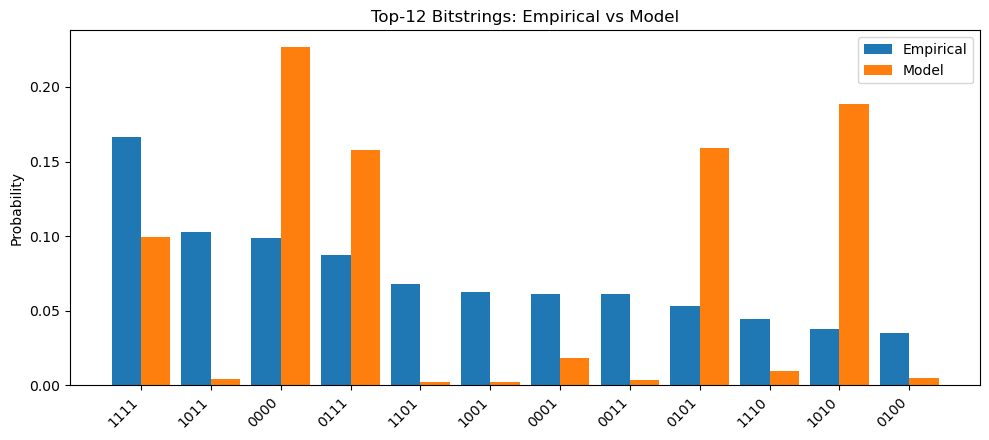

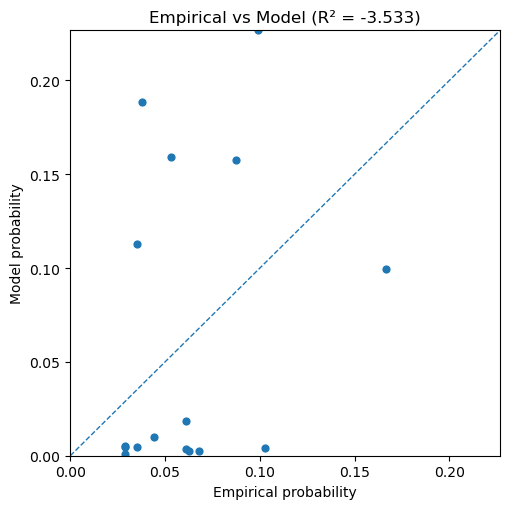

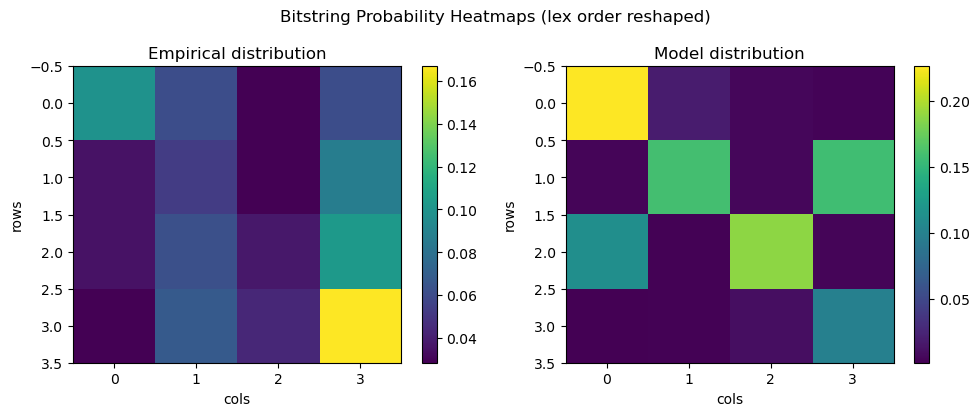

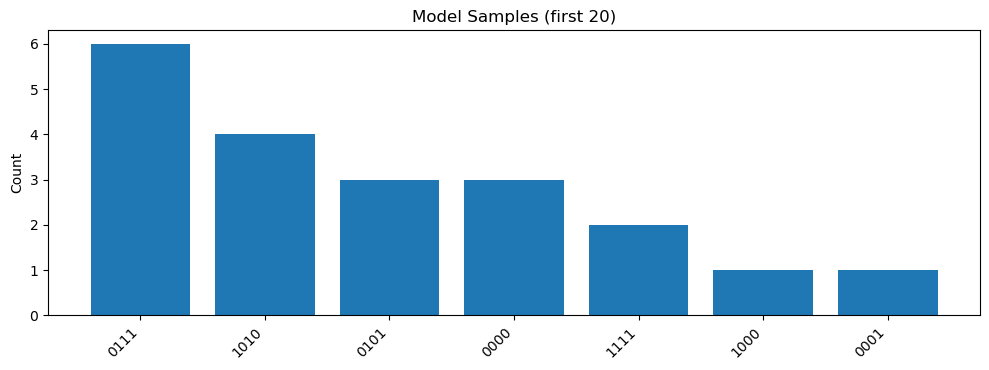

Used columns (4): ['f0', 'f1', 'f2', 'f3']
TV distance: 0.532 | KL(data||model): 1.137


In [25]:

from collections import Counter



#Training loss curve (MMD checkpoints) 
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(losses)+1), losses, marker="o")
plt.xlabel("Checkpoint")
plt.ylabel("MMD^2")
plt.title("QBM Training Loss (MMD^2)")
plt.tight_layout()
plt.show()

# Empirical vs Model: top‑K bitstrings
K = min(12, 2**n_qubits)  
def topk(d, k):
    return dict(sorted(d.items(), key=lambda kv: -kv[1])[:k])

emp_top = topk(empirical, K)
mod_top = {k: model.get(k, 0.0) for k in emp_top.keys()}

labels = list(emp_top.keys())
x = np.arange(len(labels))
width = 0.42

plt.figure(figsize=(10, 4.5))
plt.bar(x - width/2, [emp_top[l] for l in labels], width, label="Empirical")
plt.bar(x + width/2, [mod_top[l] for l in labels], width, label="Model")
plt.xticks(x, labels, rotation=45, ha="right")
plt.ylabel("Probability")
plt.title(f"Top-{len(labels)} Bitstrings: Empirical vs Model")
plt.legend()
plt.tight_layout()
plt.show()

all_keys = sorted(set(empirical) | set(model))  
emp_vec = np.array([empirical.get(k, 0.0) for k in all_keys])
mod_vec = np.array([model.get(k, 0.0) for k in all_keys])


ss_res = np.sum((emp_vec - mod_vec)**2)
ss_tot = np.sum((emp_vec - emp_vec.mean())**2) if len(emp_vec) > 1 else 0.0
r2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else np.nan

plt.figure(figsize=(5.2, 5.2))
plt.scatter(emp_vec, mod_vec, s=24)
lims = [0, max(1e-12 + emp_vec.max(), 1e-12 + mod_vec.max())]
plt.plot(lims, lims, linestyle="--", linewidth=1)  # y=x
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Empirical probability")
plt.ylabel("Model probability")
plt.title(f"Empirical vs Model (R² = {r2:.3f})")
plt.tight_layout()
plt.show()


num_states = 2**n_qubits
rows = 2**(n_qubits // 2)
cols = 2**(n_qubits - (n_qubits // 2))

def probs_to_grid(prob_dict):
    vec = np.array([prob_dict.get(format(i, f"0{n_qubits}b"), 0.0) for i in range(num_states)])
    return vec.reshape(rows, cols)

emp_grid = probs_to_grid(empirical)
mod_grid = probs_to_grid(model)

fig, axes = plt.subplots(1, 2, figsize=(10, 4.2))
im0 = axes[0].imshow(emp_grid, aspect="auto")
axes[0].set_title("Empirical distribution")
axes[0].set_xlabel("cols"); axes[0].set_ylabel("rows")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(mod_grid, aspect="auto")
axes[1].set_title("Model distribution")
axes[1].set_xlabel("cols"); axes[1].set_ylabel("rows")
fig.colorbar(im1, ax=axes[1])

plt.suptitle("Bitstring Probability Heatmaps (lex order reshaped)")
plt.tight_layout()
plt.show()

Nshow = min(40, len(samples))
sample_counts = Counter(samples[:Nshow])
labels_s = list(sample_counts.keys())
vals_s = [sample_counts[k] for k in labels_s]

plt.figure(figsize=(10, 3.8))
plt.bar(np.arange(len(labels_s)), vals_s)
plt.xticks(np.arange(len(labels_s)), labels_s, rotation=45, ha="right")
plt.ylabel("Count")
plt.title(f"Model Samples (first {Nshow})")
plt.tight_layout()
plt.show()

print(f"Used columns ({len(used_cols)}): {used_cols}")
print(f"TV distance: {tv:.3f} | KL(data||model): {kl:.3f}")